In [ ]:
!unzip -q /content/drive/My\ Drive/ADAS/bdd100k_drivable_maps.zip

In [ ]:
!unzip -q /content/drive/My\ Drive/ADAS/bdd100k.zip

In [ ]:
!pip install segmentation-models-pytorch==0.1.0

     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16032 sha256=06ff7177906be821e61f1632aea3d283ad83c9723238336c83a1de351292fc27
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=09241ac90986a0db0cb7466cf52351bdf11d759f9028cd1fb4ced5f29dda877d
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
!mv /content/bdd100k/images/100k/train/testA/*.jpg /content/bdd100k/images/100k/train
!mv /content/bdd100k/images/100k/train/testB/*.jpg /content/bdd100k/images/100k/train
!echo /content/bdd100k/images/100k/train/trainA/*.jpg | xargs mv -t /content/bdd100k/images/100k/train
!mv /content/bdd100k/images/100k/train/trainB/*.jpg /content/bdd100k/images/100k/train
!rm -rf "/content/bdd100k/images/100k/test"

In [ ]:
import os
import pathlib
from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import albumentations as albu
import matplotlib.pyplot as plt
import torchvision
import torch
import segmentation_models_pytorch as smp
import numpy as np
from PIL import Image
from torch.optim import lr_scheduler
from albumentations.pytorch import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage.io import imread, imshow
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [ ]:
torch.manual_seed(42) 
np.random.seed(42)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
IMAGE_DIR = Path("/content/bdd100k/images/100k")
MASK_DIR = Path("/content/bdd100k/drivable_maps/color_labels")

MEAN_FOR_NORMALIZE = np.array([0.485, 0.456, 0.406])
STD_FOR_NORMALIZE = np.array([0.229, 0.224, 0.225])
IMG_CHANNELS = 3

In [ ]:
image_path_files = sorted(list(IMAGE_DIR.rglob('*/*.jpg')))
mask_path_files = sorted(list(MASK_DIR.rglob('*/*.png')))

In [ ]:
# bad_image = []
# bad_mask = []
# for i in range(len(image_path_files)):
#   if imread(image_path_files[i]).shape[2] !=3 or imread(mask_path_files[i]).shape[2] !=3:
#     bad_image.append(image_path_files[i])
#     bad_mask.append(mask_path_files[i])

In [ ]:
# with open("bad_image_path.txt", "w") as output:
#     output.write(str(bad_image))

In [ ]:
# with open("bad_mask_path.txt", "w") as output:
#     output.write(str(bad_mask))

In [ ]:
with open('bad_image_path.txt', 'r') as f:
    bad_image = [pathlib.Path(line.strip()) for line in f]

In [ ]:
for i in bad_image:
  if i in image_path_files:
    image_path_files.remove(i)

In [ ]:
with open('bad_mask_path.txt', 'r') as f:
    bad_mask = [pathlib.Path(line.strip()) for line in f]

In [ ]:
for i in bad_mask:
  if i in mask_path_files:
    mask_path_files.remove(i)

In [ ]:
image_path_files[-1]

PosixPath('/content/bdd100k/images/100k/val/ca6927ab-497d6b29.jpg')

In [ ]:
mask_path_files[-1]

PosixPath('/content/bdd100k/drivable_maps/color_labels/val/ca6927ab-497d6b29_drivable_color.png')

# Let's look at the pictures

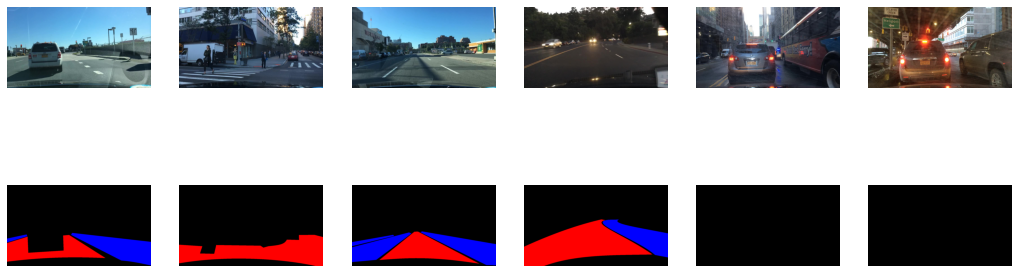

In [ ]:
image = []
mask = []
for i in range(10, 16):
  image.append(imread(os.path.join(image_path_files[i])))
  mask.append(imread(os.path.join(mask_path_files[i])))

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(image[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(mask[i])
plt.show();

# Load data

In [ ]:
class Bdd100k(Dataset):
    def __init__(self, image_files, mask_files, transforms):
        self.image_dir = image_files
        self.mask_dir = mask_files
        self.transforms = transforms

    def __len__(self):
            return len(self.image_dir)


    def load_image(self, file):
        image = Image.open(file)

        return image
    
    def __getitem__(self, idx):

        image_path = os.path.join(self.image_dir[idx])
        mask_path = os.path.join(self.mask_dir[idx])
        

        img = np.array(self.load_image(self.image_dir[idx]))
        mask = np.array(self.load_image(self.mask_dir[idx]))

        # sample = {'image': img, 'mask': mask}
        
        if self.transforms is not None:
            # sample = self.transforms(**sample)
            sample = self.transforms(image=img, mask=mask)
            img, mask = sample['image'], sample['mask']

        mask = mask.squeeze(0).permute(2, 0, 1)
        mask[1] = -(mask[0] + mask[2] - 1)
        
        # return sample
        return img, mask

In [ ]:
train_transforms = albu.Compose([
                                  albu.HorizontalFlip(),
                                  albu.Resize(256, 256, p=1),
                                  albu.OneOf([
                                      albu.MotionBlur(p=0.2),
                                      albu.MedianBlur(blur_limit=3, p=0.1),
                                      albu.Blur(blur_limit=3, p=0.1), ], p=0.2),
                                  albu.OneOf([
                                      albu.HueSaturationValue(10,15,10), #Randomly change hue, saturation and value of the input image.
                                      albu.CLAHE(clip_limit=2),  #Contrast Limited Adaptive Histogram Equalization to the input image.
                                      albu.RandomBrightnessContrast(),], p=0.3),
                                  albu.Normalize(),
                                  ToTensor()
                                ])

val_transforms = albu.Compose([
                                  albu.Resize(256, 256, p=1),
                                  albu.Normalize(),
                                  ToTensor()
                                ])


In [ ]:
path_image_train_files, path_image_val_files, path_mask_train_files, path_mask_val_files = \
                train_test_split(image_path_files, mask_path_files, test_size=0.2, random_state=42)
                
path_image_train_files, path_image_test_files, path_mask_train_files, path_mask_test_files  = \
                train_test_split(path_image_train_files, path_mask_train_files, test_size=0.125, random_state=42) # 0.125 x 0.8 = 0.1

In [ ]:
train_dataset = Bdd100k(path_image_train_files, path_mask_train_files, train_transforms)
val_dataset = Bdd100k(path_image_val_files, path_mask_val_files, val_transforms)
test_dataset = Bdd100k(path_image_test_files, path_mask_test_files, val_transforms)

In [ ]:
train_dataloader = DataLoader(
        train_dataset,
        batch_size=10,
        num_workers=12,
        shuffle=True)
val_dataloader = DataLoader(
        val_dataset,
        batch_size=10,
        num_workers=4,
        shuffle=False)
test_dataloader = DataLoader(
        test_dataset,
        batch_size=10,
        num_workers=4,
        shuffle=False)

In [ ]:
def tensor_imshow(img, title=None, plt_ax=plt, default=False):
    '''Imshow for tensor'''
    img = img.numpy().transpose((1, 2, 0))
    img = STD_FOR_NORMALIZE * img + MEAN_FOR_NORMALIZE
    img = np.clip(img, 0, 1)
    plt_ax.imshow(img)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

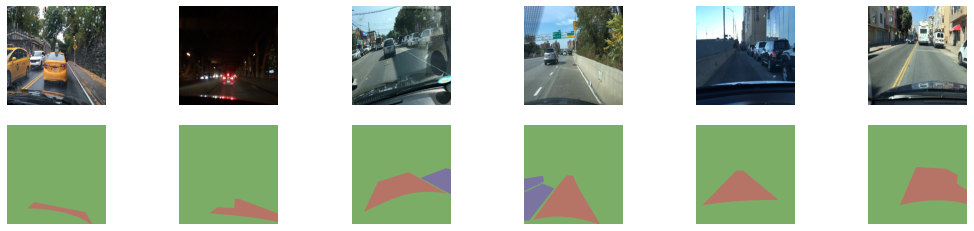

In [ ]:
batch = next(iter(val_dataloader))
plt.figure(figsize=(18, 4))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    tensor_imshow(batch[0][i])
    plt.subplot(2, 6, i+7)
    plt.axis("off")
    tensor_imshow(batch[1][i])
plt.show();

# Train

In [ ]:
ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'
ACTIVATION = 'softmax2d'
EPOCHS = 48

def get_Unet():
  model = smp.Unet(
      encoder_name=ENCODER, 
      encoder_weights=ENCODER_WEIGHTS,
      in_channels=3, 
      classes=3, activation=ACTIVATION)
  return model

# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
model = get_Unet().to(DEVICE)
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-4), 
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
max_score = 0
for i in range(0, EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_dataloader)
    valid_logs = valid_epoch.run(val_dataloader)

    with open("/content/drive/My Drive/ADAS/train_logs.txt", "a") as output:
      output.write(str(train_logs) + '\n')
    with open("/content/drive/My Drive/ADAS/valid_logs.txt", "a") as output:
      output.write(str(valid_logs) + '\n')

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model.state_dict(), f"/content/drive/My Drive/ADAS/model_segm_efficientnet_b0.pth")
        print('Model saved!')
        
    if i == 24:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

In [7]:
#Max dice score:
# {'dice_loss': 0.03162835003139088, 'iou_score': 0.938972687616813}

# Test

In [ ]:
# load best saved checkpoint
best_model = torch.load('/content/drive/My Drive/ADAS/model_segm_efficientnet_b0.pth')

In [ ]:
evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

In [ ]:
batch = next(iter(test_dataloader))
pred = best_model.predict(batch[0].to(DEVICE))
pred = (pred.cpu().squeeze().round())

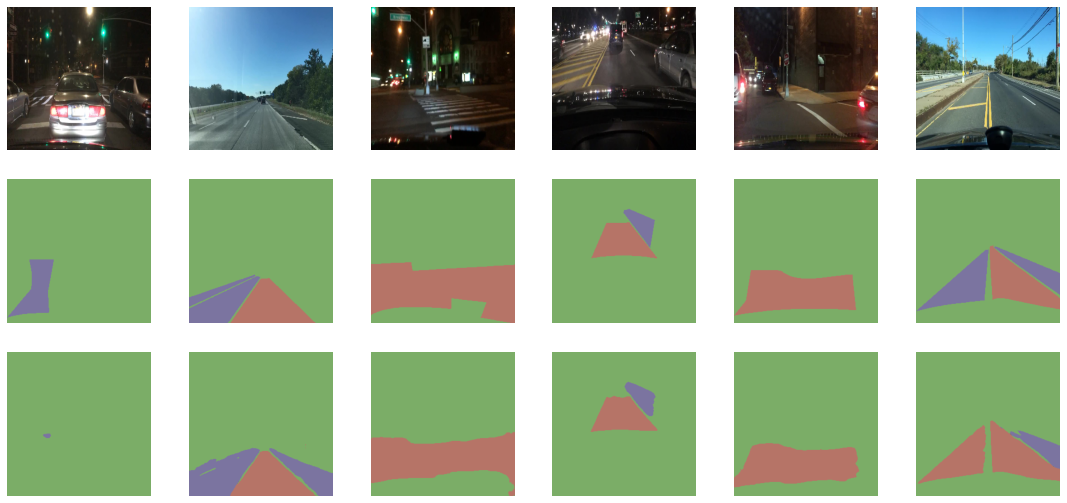

In [ ]:
plt.figure(figsize=(19, 9))
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.axis("off")
    tensor_imshow(batch[0][i])
    plt.subplot(3, 6, i+7)
    plt.axis("off")
    tensor_imshow(batch[1][i])
    plt.subplot(3, 6, i+13)
    plt.axis("off")
    tensor_imshow(pred[i])
plt.show();